# Coin Classifier

In [313]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load the data

In [314]:
data_dir = '/home/pablo/Desktop/stuff/coin_cnn/data'

train_dir = data_dir + '/train'
valid_dir = data_dir + '/validation'
test_dir = data_dir + '/test'

In [315]:
train_transforms = transforms.Compose([transforms.Resize(224),
                                        transforms.CenterCrop(224),
                                        transforms.RandomRotation(25),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225]
                                        )
                                      ])

valid_transforms = transforms.Compose([transforms.Resize(224),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(), 
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225]
                                        )
                                      ])

test_transforms = transforms.Compose([transforms.Resize(224),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225]
                                        )
                                     ])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=True)

In [316]:
dataloaders = {'train_loader': train_loader, 'valid_loader': valid_loader, 'test_loader': test_loader}

### Visualize the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


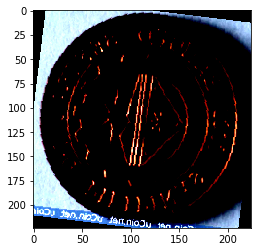

In [317]:
images, labels = next(iter(dataloaders['train_loader']))
image = images[0].permute(2, 1, 0).numpy()
imgplot = plt.imshow(image)
plt.show()

### Label Mapping

In [318]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
# Make sure it is loaded right
cat_to_name["23"]

'5 Cents,Canadian Dollar,canada'

### Load the models

In [319]:
# Pre-trained  resnet152
model_resnet152 = models.resnet152(pretrained=True)

# Freeze parameters in pre trained ResNET
for param in model_resnet152.parameters():
    param.requires_grad = False

out_classes = len(cat_to_name)

model_resnet152.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, out_classes)
)

# Check the modified fc layer
print(model_resnet152.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2)
  (3): Linear(in_features=1024, out_features=211, bias=True)
)


### Check for GPU

In [320]:
is_GPU_available = torch.cuda.is_available()

if is_GPU_available:
    device = 'cuda'
    print('training on GPU')
else:
    device = 'cpu'
    print('training on CPU')
    
my_model = model_resnet152

my_model.to(device)

training on GPU


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

### Save and Load the checkpoint

In [321]:
model_resnet152.class_to_idx = train_dataset.class_to_idx

def save_model(model, val_loss):
    model = {
        'name': 'resnet152',
        'state_dict': model.state_dict(),
        'fc': model.fc,
        'min_val_loss': val_loss,
        'class_to_idx': model.class_to_idx,
    }
    
    torch.save(model, 'checkpoint_cnn_resnet152.pth')

In [322]:
def load_checkpoint_resnet152(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet152(pretrained=True)
    
    # Freeze parameters (in case we want to train more)
    for param in model.parameters():
        param.requires_grad = False
        
    model.fc = checkpoint['fc']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

### Train the network

In [323]:
def train (my_model, criterion, epochs = 15, lr=0.003, min_valid_loss=np.Inf):
    
    optimizer = optim.Adam(my_model.parameters(), lr)
    
    for epoch in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0
        accuracy = 0.0
        
        my_model.train()
        for images, labels in dataloaders['train_loader']:
            optimizer.zero_grad()

            # Move tensors to GPU if available
            inputs, labels = images.to(device), labels.to(device)

            # Forward pass
            output = my_model(inputs)

            loss = criterion(output, labels)
            loss.backward()

            # Update weights
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)

        my_model.eval()
        for inputs, labels in dataloaders['valid_loader']:
            # Move tensors to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            output = my_model(inputs)

            val_loss = criterion(output, labels)
            
            valid_loss += val_loss.item() * inputs.size(0)
            
            # Accuracy
            _, predicted = output.topk(1, dim=1)
            equals = predicted == labels.view(*predicted.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        # Calculate the losses
        train_loss = train_loss/len(dataloaders["train_loader"].dataset)
        valid_loss = valid_loss/len(dataloaders["valid_loader"].dataset)
        accuracy = (accuracy/len(dataloaders["valid_loader"]))*100
        
        print('Epoch {}'.format(epoch + 1))
        print('Train loss: {0:.2f}'.format(train_loss))
        print('Valid loss: {0:.2f}'.format(valid_loss))
        print('Accuracy: {0:.2f}%'.format(accuracy))
        
        if valid_loss < min_valid_loss:
            min_valid_loss = valid_loss
            save_model(my_model, valid_loss)
            # best_model stores the model with the lowest valid loss
            best_model = my_model
            print('Valid loss has decreased. Saving model...')
        
        print('--------------------------------------------')

### Defining hyperparameters

In [324]:
my_model = load_checkpoint_resnet152('checkpoint_cnn_resnet152.pth').to(device)
epochs = 15
lr = 0.00003
criterion = nn.CrossEntropyLoss()

### Train the model

In [ ]:
train(my_model=my_model, criterion=criterion, epochs=epochs, lr=lr)

Epoch 1
Train loss: 1.30
Valid loss: 1.93
Accuracy: 60.58%
Valid loss has decreased. Saving model...
--------------------------------------------
Epoch 2
Train loss: 1.26
Valid loss: 1.82
Accuracy: 61.63%
Valid loss has decreased. Saving model...
--------------------------------------------
Epoch 3
Train loss: 1.27
Valid loss: 1.98
Accuracy: 61.51%
--------------------------------------------
Epoch 4
Train loss: 1.24
Valid loss: 1.75
Accuracy: 63.60%
Valid loss has decreased. Saving model...
--------------------------------------------
Epoch 5
Train loss: 1.24
Valid loss: 1.82
Accuracy: 61.86%
--------------------------------------------
Epoch 6
Train loss: 1.20
Valid loss: 1.86
Accuracy: 61.05%
--------------------------------------------
Epoch 7
Train loss: 1.20
Valid loss: 1.75
Accuracy: 62.91%
Valid loss has decreased. Saving model...
--------------------------------------------
Epoch 8
Train loss: 1.18
Valid loss: 1.83
Accuracy: 63.02%
--------------------------------------------


In [ ]:
# Load the best model
my_model = load_checkpoint_resnet152('checkpoint_cnn_resnet152.pth')

### Test accuracy

In [ ]:
def check_accuracy_on_test(model, data, cuda=False):
    model.eval()
    model.to(device) 
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in (dataloaders[data]):
            
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, predicted = torch.topk(output, 1)
            
            equals = predicted == labels.view(*predicted.shape)
            correct += int(torch.sum(equals))
            total += len(images)
           
    accuracy = '{0:.2f}'.format((correct / total)*100)    
    print('Accuracy of the network on the test images: {}/{} --> {}%'.format(correct, total, accuracy))
    
check_accuracy_on_test(my_model, 'test_loader', True)

### Pre-process input image

When we recieve an input image we need to pre-process it so that it has the right dimensions as well as the proper normalizationo before we feed it to the  network.

In [ ]:
import PIL
from PIL import Image

In [ ]:
def process_image (image):
    image_pil = Image.open(image)
    width, height = image_pil.size
    if width > height:
        image_pil.thumbnail((np.Inf, 256))
    else:
        image_pil.thumbnail((256, np.Inf))
    
    # Crop image
    image_pil = image_pil.resize((224, 224))
    
    # Convert to numpy and normalize
    np_image = np.array(image_pil)/255
                                            
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    np_image = (np_image - mean)/std
    
    # Transpose for image to have the correct dimensions, depth first.
    np_image = np_image.transpose(2, 0, 1)
    
    # Convert to tensor
    tensor_image = torch.from_numpy(np_image).float()
    
    return tensor_image

In [ ]:
test_image_path = '/home/pablo/Desktop/stuff/coin_cnn/data/test/10/014__5 Centavos_brazil.jpg'

# Permute dimensions just for plotting the image.
processed_image = process_image(test_image_path).permute(1, 2, 0)
imgplot = plt.imshow(processed_image)
plt.show()

### Make a prediction

This function will make a prediction. We pass the function a pre-processed image and the model and it returns the top 5 predictions.

In [ ]:
def predict(image, model, topk=5):
    model.eval()
    model.to("cpu")
    
    # Load the image
    image = image.unsqueeze(0)

    # Forward pass.
    output = model.forward(image)
    # Get the top element
    top_prob, top_class = torch.topk(output, topk)
    
    # Get the probabilities
    top_prob = top_prob.exp()
    
    # Convert to arrays.
    top_prob = top_prob.squeeze().detach().numpy()
    top_class = top_class.squeeze().detach().numpy()
    
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    
    # Get the actual labels
    top_classes = [idx_to_class[i] for i in top_class]
    
    return top_prob, top_classes

### Sanity Checking 

Before we finish lets check our predictions with some of our test images to make sure that the network is not doing anything strange.

In [ ]:
def get_class_name (model, top_class):
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    # Get the actual labels
    top_classes = [idx_to_class[i] for i in top_class]
    
    return top_classes

In [ ]:
def plot_predictions(img, top_prob_array, classes, mapper, labels):
    # imshow expects the 3rd dimension at the end.
    img = img.numpy().transpose(1,2,0)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    
    # The real coin name
    coin_name = cat_to_name[str(labels[0])]
    ax1.set_title(coin_name)
    ax1.imshow(img)
    
    # The predictions
    y_pos = np.arange(len(top_prob_array))
    ax2.barh(y_pos, top_prob_array)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()
    
    if labels[0] == classes[0]:
        print('Correct!')
    else:
        print('Incorrect!')

In [ ]:
dataiter = iter(dataloaders["test_loader"])
images, labels = dataiter.next()
img = images[0]
labels = get_class_name(my_model, labels.numpy())

# Get the probabilities and classes
probs, classes = predict(img, my_model)
plot_predictions(img, probs, classes, cat_to_name, labels)